In [45]:
param = {'C': 0.04773295631615594,
    'max_iter': 5000,
    'dual': True,
    'random_state': 1000}


stage1_model_name = "logistic_regression"

stage1_params = {
    "l1_ratio": 0,
    "C": 0.3,                 # buon trade-off bias/varianza per TF-IDF
    "solver": "saga",         # unico che scala bene + supporta class_weight
    "max_iter": 5000,
    "class_weight": "balanced",
    "random_state": 1000
}

stage2_model_name = 'linear_svm'
stage2_params = {**param, "class_weight": {0: 1.0, 3: 2.4, 5: 1.8}}

stage2_out_model_name = 'linear_svm'
stage2_out_params = {**param, "class_weight": {1: 2.2, 2: 2.1, 4: 2.7, 6: 7.6}}

big = True
group_labels = (0,3,5)

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from src.preprocessing import build_preprocess
from src.utils import load_data, plot_cm
from src.config import *
from src.models import train_model
from src.preprocessing import initial_prep

import numpy as np
from sklearn.model_selection import train_test_split


def stage_1(X_train, X_test, y_train, y_test):
    """
    The purpose of this stage is to predict which sample of the test
    are in the group (0,3,5) or in the group (1,2,4,6).
    So we train on X_train and y_train mapped to 0/1 (1 if y in group, 0 otherwise)
    and we make and return binary prediction on X_test.
    """
    # Binary target: 1 if in group, else 0
    y_bin_train = y_train.isin(group_labels).astype(int)
    y_bin_test = y_test.isin(group_labels).astype(int)  
    preprocess1 = build_preprocess(stage1_model_name, big=big)
    X_train_prep = preprocess1.fit_transform(X_train)
    X_test_prep = preprocess1.transform(X_test)

    res1, pred_in_group = train_model(
        stage1_model_name, stage1_params,
        X_train_prep, X_test_prep,
        y_bin_train, y_bin_test
    )
    # pred_in_group: array {0,1}
    pred_in_group = np.asarray(pred_in_group).astype(int)
    return res1, pred_in_group

def stage_2(X_train, X_test, y_train, y_test, pred_in_group, out=False):
    """
    On the samples of the train for which we have predicted to be in group (1) in the stage 1, we know develop a model that can distinguish between the 3 classes (0, 3, 5)
    """
    if out:
        train_mask_g = ~(y_train.isin(group_labels))
        test_mask_g = (pred_in_group == 0)
        model_name = stage2_out_model_name
        params = stage2_out_params
    else:
        train_mask_g = y_train.isin(group_labels)
        test_mask_g = (pred_in_group == 1)
        model_name = stage2_model_name
        params = stage2_params

    X_train_g = X_train[train_mask_g]
    y_train_g = y_train[train_mask_g]

    # Predict stage2 only on test samples predicted as in-group by stage1
    
    X_test_g = X_test[test_mask_g]
    y_test_g = y_test[test_mask_g]

    preprocess2 = build_preprocess(model_name, big=big)
    X_train_g_prep = preprocess2.fit_transform(X_train_g)
    X_test_g_prep = preprocess2.transform(X_test_g)

    res2, pred_intra_group = train_model(
        model_name, params,
        X_train_g_prep, X_test_g_prep,
        y_train_g, y_test_g
    )
    return res2, pred_intra_group

def performance_two_stage():
    """
    Two-stage classifier:
      Stage1: predict IN_GROUP ({0,3,5}) vs OUT_GROUP (others)
      Stage2: if IN_GROUP, predict among {0,3,5}; else use mapped class from stage1? (we keep original OUT predictions as OUT)
    Returns result dict, y_pred (7-class), and idx_test.
    """
    news_df = load_data(DEVELOPMENT_PATH)
    X = news_df.drop(columns=["y"])
    y = news_df["y"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )

    # Stage 1 - the goal is to separate in test set sample that belongs to group (0,3,5) and others
    res1, pred_in_group = stage_1(X_train, X_test, y_train, y_test)

    # Stage 2 - In
    res2, pred_intra_group = stage_2(X_train, X_test, y_train, y_test, pred_in_group)    

    # Stage 2 - Out
    res2_extra, pred_extra_group = stage_2(X_train, X_test, y_train, y_test, pred_in_group, out=True)    


    # Final assembler 

    test_mask_in = (pred_in_group == 1)
    test_mask_out = ~test_mask_in

    y_pred_final = np.empty(len(y_test), dtype=int)
    y_pred_final[test_mask_in] = np.asarray(pred_intra_group).astype(int)
    y_pred_final[test_mask_out] = np.asarray(pred_extra_group).astype(int)

    return y_pred_final, y_test, res1, res2, res2_extra


In [47]:
y_pred_final, y_test, res1, res2, res2_extra = performance_two_stage()

In [48]:
from src.evaluation import classification_metrics_full
final_res = classification_metrics_full(y_test, y_pred_final)

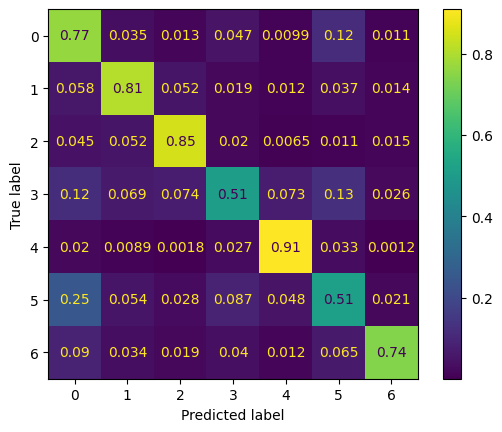

In [49]:
plot_cm(final_res['confusion_matrix'])

In [50]:
final_res

{'aggregated': {'precision_macro': 0.7139322040419328,
  'recall_macro': 0.7280849198984616,
  'f1_macro': 0.7192531551335649},
 'per_class': {'precision': array([0.75557963, 0.7470852 , 0.82735426, 0.62089356, 0.81750267,
         0.56244344, 0.66666667]),
  'recall': array([0.76570048, 0.80795344, 0.85023041, 0.50998381, 0.90919881,
         0.5134242 , 0.74010327]),
  'f1': array([0.76060639, 0.77632805, 0.83863636, 0.56      , 0.86091599,
         0.5368171 , 0.70146819]),
  'support': array([4554, 2062, 2170, 1853, 1685, 2421,  581])},
 'confusion_matrix': array([[3487,  159,   59,  216,   45,  537,   51],
        [ 120, 1666,  107,   40,   24,   76,   29],
        [  98,  113, 1845,   43,   14,   24,   33],
        [ 223,  127,  138,  945,  135,  237,   48],
        [  33,   15,    3,   45, 1532,   55,    2],
        [ 602,  130,   67,  210,  117, 1243,   52],
        [  52,   20,   11,   23,    7,   38,  430]])}

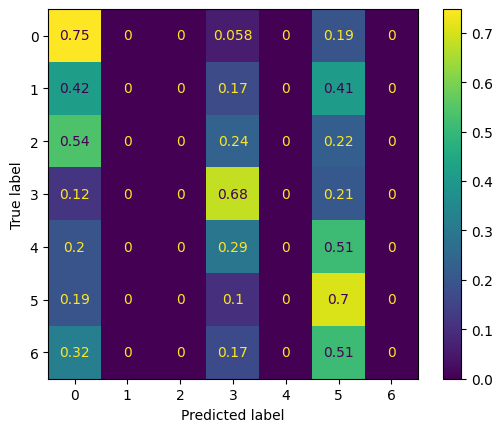

In [42]:
plot_cm(res2['confusion_matrix'])

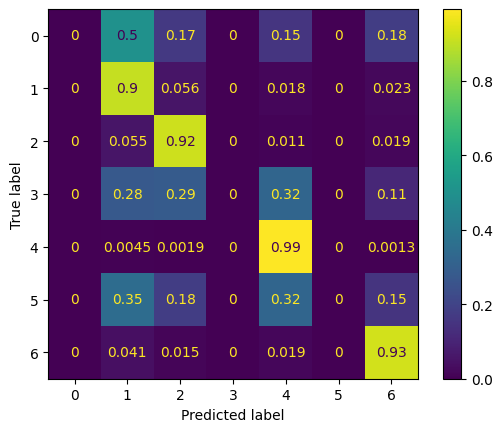

In [43]:
plot_cm(res2_extra['confusion_matrix'])

In [44]:
from src.evaluation.run import performance

param = {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}
perf, y_pred, test_idxs = performance('linear_svm', param, True)

(61302, 233075)


In [58]:
y_pred[np.isin(y_pred, [0,3,5])]

array([0, 0, 0, ..., 0, 0, 5], shape=(8117,))

In [54]:
test_idxs

Index([72741,  8107, 69402, 72846, 72210, 12713, 16577, 15577,  3932, 12501,
       ...
       60403,  1341,  6356, 22108, 35670, 26451,  4432, 54245, 43940,  6885],
      dtype='int64', name='Id', length=15326)